In [22]:
json_file_path = "CareerAdvisoryService.job_profiles_en_100_6thFeb.json"


In [23]:
import json

# Load JSON file
with open(json_file_path, "r", encoding="utf-8") as file:
    json_data = json.load(file)  # Load JSON data as a Python dictionary or list

# Convert JSON data into a list of strings
if isinstance(json_data, dict):  # If JSON is a dictionary
    string_list = [json.dumps({key: value}) for key, value in json_data.items()]
elif isinstance(json_data, list):  # If JSON is already a list
    string_list = [json.dumps(item) for item in json_data]
else:
    raise ValueError("Unsupported JSON format")

# Print the result
# print(string_list)

In [24]:
from langchain_core.documents import Document  # Import Document class
# Convert strings to LangChain Document objects
cas_docs = [Document(page_content=text) for text in string_list]

In [25]:
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME)

vector_db = FAISS.from_documents(cas_docs, embedding_model)
print(vector_db.index.ntotal)

100


In [27]:
# Save FAISS index
vector_db.save_local("faiss_index")

# Load FAISS index with safe deserialization
local_vector_db = FAISS.load_local("faiss_index", embedding_model, allow_dangerous_deserialization=True)

# Perform similarity search
query = "What does a Clinical Data Manager do?"
similarity_search_docs = local_vector_db.similarity_search(query)

# Print results
# print(similarity_search_docs)

In [38]:
retriever = local_vector_db.as_retriever()
retrieved_docs = retriever.invoke(query)
# retrieved_docs

In [51]:
import getpass
import os

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain.chat_models import init_chat_model

# llm = init_chat_model("llama3-8b-8192", model_provider="groq")
# llm = init_chat_model("llama-3.3-70b-versatile", model_provider="groq")


In [2]:
import getpass
import os

if not os.environ.get("AZURE_OPENAI_API_KEY"):
  os.environ["AZURE_OPENAI_API_KEY"] = getpass.getpass("Enter API key for Azure: ")

Enter API key for Azure:  ········


In [3]:
if not os.environ.get("AZURE_OPENAI_ENDPOINT"):
  os.environ["AZURE_OPENAI_ENDPOINT"] = getpass.getpass("Enter AZURE_OPENAI_ENDPOINT for Azure: ")

Enter AZURE_OPENAI_ENDPOINT for Azure:  ········


In [4]:
if not os.environ.get("AZURE_OPENAI_DEPLOYMENT_NAME"):
  os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"] = getpass.getpass("Enter AZURE_OPENAI_DEPLOYMENT_NAME for Azure: ")

Enter AZURE_OPENAI_DEPLOYMENT_NAME for Azure:  ········


In [5]:
if not os.environ.get("AZURE_OPENAI_API_VERSION"):
  os.environ["AZURE_OPENAI_API_VERSION"] = getpass.getpass("Enter AZURE_OPENAI_API_VERSION for Azure: ")

Enter AZURE_OPENAI_API_VERSION for Azure:  ········


In [7]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
)

In [44]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

 ········


In [28]:
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    PromptTemplate
)

# System message template
system_message = SystemMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=[],
        template="You are an assistant for question-answering tasks."
    )
)

# Human message template
human_message = HumanMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=['context', 'question'],
        template="Question: {question}\nContext: {context}\nAnswer:"
    )
)


chat_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
# Define the input variables
# input_data = {
#     "question": "What is the capital of France?",
#     "context": "France is a country in Western Europe."
# }

# # Invoke the prompt with the input data
# prompt_value = chat_prompt.invoke(input_data)


In [38]:
from langchain import hub
hub_prompt = hub.pull("rlm/rag-prompt")
hub_prompt

D:\Dhananjay\Pro\DCode\MyAIPractice\ai_env\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [32]:
import bs4
# from langchain import hub
from langchain.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict



# Define prompt for question-answering
# prompt = hub.pull("rlm/rag-prompt")

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an assistant for question-answering tasks."),
    ("user", "Question: {question}\nContext: {context}\nAnswer:")
])




# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = local_vector_db.similarity_search(state["question"])
    return {"context": retrieved_docs}


# def generate(state: State):
#     docs_content = "\n\n".join(doc.page_content for doc in state["context"])
#     messages = prompt.invoke({"question": state["question"], "context": docs_content})
#     response = llm.invoke(messages)
#     return {"answer": response.content}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    # input_data = {"question": state["question"],"context": docs_content}
    # messages = chat_prompt.invoke(input_data)
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

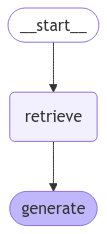

In [12]:
graph

In [13]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are an assistant for question-answering tasks.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Question: {question}\nContext: {context}\nAnswer:'), additional_kwargs={})])

In [35]:
question = "I know data science"


response = graph.invoke({"question": question})
print(response["answer"])

It seems like you have a strong understanding of data science, particularly in the context of various job profiles in the industry. Here’s a summary of some key aspects related to data science roles based on the information provided:

### Data Entry Clerk in Data Management
- **General Description**: This role involves inputting and managing data in computer systems, ensuring accuracy and integrity of the data.
- **Day in the Life**: Tasks primarily include entering data from various sources, verifying accuracy, updating records, and sometimes generating reports.
- **Preparation for the Role**: 
  - **Education**: Typically requires at least a 12th pass. Higher education may be preferred in large cities.
  - **Training**: Short-term certificate programs in computer applications or data entry are beneficial.
  - **Experience**: Prior experience is not strictly necessary, but internships can help.
- **Skills Needed**: 
  - **Technical Proficiency (Score: 7)**: Familiarity with data entry

In [36]:
print(f'Context: {response["context"]}\n\n')

Context: [Document(id='a4af6831-00d3-4afd-be59-f5a90023352e', metadata={}, page_content='{"_id": {"$oid": "66603705ed43a30f94899288"}, "createdAt": [{"$date": "2024-06-05T15:29:33.368Z"}], "updatedAt": {"$date": "2024-12-23T08:18:34.733Z"}, "deleted": false, "sector": "IT / ITeS (Information Technology / Information Technology enabled Services)", "collegeCategory": "Non-College", "subSector": "Data Management", "jobProfile": {"generalDescription": {"text": "A Data Entry Clerk in the IT/ITeS sector inputs data into computer systems. They ensure the accuracy of the data entered. They may also update and maintain information on computer systems. This role is crucial for managing and organizing data. It does not require a college degree.", "mediaURL": "https://wofileservicedev1.blob.core.windows.net/career-advisor-images/Data%20Entry%20Clerk-1722425708552.png", "mediaURLs": {"male": "Data Entry Clerk-1722944604027.png", "female": "Data Entry Clerk-1722944643089.png"}}, "dayInTheLife": {"te

In [77]:
for step in graph.stream(
    {"question": question}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='cec03870-936b-41a5-bda7-a5bcc95b4665', metadata={}, page_content='{"_id": {"$oid": "66aa4ecf65480c1bedb5283b"}, "collegeCategory": "College", "jobProfile": {"generalDescription": {"text": "A Financial Analyst in the BFSI sector helps banks make smart financial decisions. They study market trends, analyze financial data, and create reports. They also help in budgeting and forecasting. Their work supports the bank\'s financial health. They often work with other departments to gather information.", "mediaURL": "https://wofileservicedev1.blob.core.windows.net/career-advisor-images/Financial%20Analyst-1722437247732.png", "mediaURLs": {"male": "Financial Analyst-1726066508823.png", "female": "Financial Analyst-1726066529917.png"}}, "dayInTheLife": {"text": "A typical day for a Financial Analyst starts with checking emails and market news. They spend a lot of time analyzing financial data and creating reports. They attend meetings to discuss their findin

In [35]:

from langchain_community.vectorstores import FAISS

vector_store = FAISS(embedding_function=embeddings)

TypeError: FAISS.__init__() missing 3 required positional arguments: 'index', 'docstore', and 'index_to_docstore_id'

In [13]:
import getpass
import os

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain.chat_models import init_chat_model

model = init_chat_model("llama-3.3-70b-versatile", model_provider="groq")

In [55]:
model.invoke("hi")

AIMessage(content="It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 36, 'total_tokens': 60, 'completion_time': 0.087272727, 'prompt_time': 0.00461582, 'queue_time': 0.232184252, 'total_time': 0.091888547}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_7b42aeb9fa', 'finish_reason': 'stop', 'logprobs': None}, id='run-d721a475-ec17-439c-9ecc-d97c745ba7bd-0', usage_metadata={'input_tokens': 36, 'output_tokens': 24, 'total_tokens': 60})

In [1]:
from langchain_community.document_loaders import JSONLoader

In [4]:
import json
from pathlib import Path
from pprint import pprint

file_path = "CareerAdvisoryService.job_profiles_en_100_6thFeb.json"


data = json.loads(Path(file_path).read_text())

In [5]:
pprint(data)

[{'_id': {'$oid': '66603705ed43a30f94899288'},
  'allPassions': [],
  'aptitudeRatings': [{'attribute': 'Logical Reasoning and Analytical Skills',
                       'attributeKey': 'logicalReasoningAndAnalyticalSkills',
                       'reason': 'Data entry requires attention to detail and '
                                 'some basic problem-solving skills.',
                       'score': '6'},
                      {'attribute': 'Verbal Ability and Communication Skills',
                       'attributeKey': 'verbalAbilityAndCommunicationSkills',
                       'reason': 'Basic communication skills are needed to '
                                 'understand instructions and report issues.',
                       'score': '5'},
                      {'attribute': 'Numerical Aptitude',
                       'attributeKey': 'numericalAptitude',
                       'reason': 'Some data entry tasks may involve numbers, '
                                 'but 

In [9]:
loader = JSONLoader(
    file_path = file_path,
    jq_schema='.messages[].content',
    text_content=False)

data = loader.load()

TypeError: JSONLoader.__init__() missing 1 required positional argument: 'jq_schema'

In [14]:
model.invoke("Hello, world!")

AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 39, 'total_tokens': 65, 'completion_time': 0.094545455, 'prompt_time': 0.00470697, 'queue_time': 0.234414878, 'total_time': 0.099252425}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_e669a124b2', 'finish_reason': 'stop', 'logprobs': None}, id='run-e85b826a-7c78-4c3c-9d5d-e928163ca289-0', usage_metadata={'input_tokens': 39, 'output_tokens': 26, 'total_tokens': 65})

In [15]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage("Translate the following from English into Italian"),
    HumanMessage("hi!"),
]

model.invoke(messages)

AIMessage(content='Ciao!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 44, 'total_tokens': 48, 'completion_time': 0.015443322, 'prompt_time': 0.004793501, 'queue_time': 0.21683793299999998, 'total_time': 0.020236823}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_7b42aeb9fa', 'finish_reason': 'stop', 'logprobs': None}, id='run-4d9dca93-01c2-4cec-a755-2bf9c29b13f3-0', usage_metadata={'input_tokens': 44, 'output_tokens': 4, 'total_tokens': 48})

In [12]:
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME)

vector_db = FAISS.from_documents(docs, embedding_model)

# Data Understanding 

In [21]:
import json
path_json = "CareerAdvisoryService.job_profiles_en_100_6thFeb.json"

# Load the JSON file
with open(path_json, "r", encoding="utf-8") as file:
    cas_data = json.load(file)

In [22]:
type(cas_data)

list

In [23]:
len(cas_data)

100

In [25]:
cas_data[89]

{'_id': {'$oid': '66c36fdea1e55c0863012ecc'},
 'collegeCategory': 'Non-College',
 'jobRole': 'Shift Supervisor',
 'jobLocation': 'India',
 'sector': 'Retail',
 'subSector': 'Store Operations',
 'generatedBy': 'OpenAI GPT-4o',
 'languageCode': 'en',
 'experienceLevel': 'entry-level',
 'jobRoleKey': 'india_retail_store_operations_entry_level_non_college_shift_supervisor',
 'createdAt': [{'$date': '2024-08-19T21:46:30.637Z'}],
 'updatedAt': {'$date': '2024-12-23T08:18:38.242Z'},
 'deleted': False,
 'aptitudeRatings': [{'attribute': 'Logical Reasoning and Analytical Skills',
   'score': '7',
   'reason': 'Shift Supervisors need to solve problems and make decisions quickly.',
   'attributeKey': 'logicalReasoningAndAnalyticalSkills'},
  {'attribute': 'Verbal Ability and Communication Skills',
   'score': '8',
   'reason': 'They must communicate clearly with staff and customers.',
   'attributeKey': 'verbalAbilityAndCommunicationSkills'},
  {'attribute': 'Numerical Aptitude',
   'score': '6',

In [26]:
type(cas_data[88])

dict

In [107]:
sample_cas_dict = cas_data[44]
type(sample_cas_dict)

dict

In [108]:
sample_cas_dict.keys()

dict_keys(['_id', 'collegeCategory', 'jobRole', 'jobLocation', 'sector', 'subSector', 'generatedBy', 'languageCode', 'experienceLevel', 'jobRoleKey', 'createdAt', 'updatedAt', 'deleted', 'aptitudeRatings', 'careerPathways', 'employers', 'geographicJobDetails', 'interestRatings', 'jobProfile', 'valueRatings', 'minEducationLevel', 'passions', 'allPassions', 'tempPassions', 'slug'])

In [109]:
sample_cas_dict["passions"]

[]

In [110]:
sample_cas_dict["jobRole"]


'Medical Device Technician'

In [111]:
sample_cas_dict["jobRoleKey"]


'india_healthcare_pharmaceutical_and_medical_devices_entry_level_non_college_medical_device_technician'

In [113]:
sample_cas_dict["experienceLevel"]


'entry-level'

In [118]:
sample_cas_dict["jobProfile"]


{'generalDescription': {'text': 'A Medical Device Technician helps with the setup, maintenance, and repair of medical equipment. They ensure devices work properly and safely. They may also assist in training healthcare staff on how to use the equipment. This role is important in hospitals and clinics. They work closely with other healthcare professionals.',
  'mediaURLs': {'male': 'Medical Device Technician_male-1726069825410.png',
   'female': 'Medical Device Technician_female-1726069846045.png'}},
 'dayInTheLife': {'text': 'A typical day for a Medical Device Technician starts with checking and calibrating medical devices. They inspect equipment for any issues and perform routine maintenance. They may be called to repair broken devices or troubleshoot problems. They also document their work and ensure all devices meet safety standards. Sometimes, they train healthcare staff on using new equipment.',
  'media': {'video': ''}},
 'reasonsLiked': [{'reason': 'The job is hands-on and invol

In [119]:
sample_cas_dict["careerPathways"]


[{'pathwayTitle': 'Technical Specialist',
  'description': 'This pathway is great for those who love working with technology and machines. Success comes from gaining deep technical knowledge and hands-on experience.',
  'jobRoles': [{'title': 'Medical Device Technician', 'years': '0-2'},
   {'title': 'Senior Medical Device Technician', 'years': '2-5'},
   {'title': 'Technical Specialist', 'years': '5-10'}]},
 {'pathwayTitle': 'Quality Assurance Expert',
  'description': 'This pathway is ideal for detail-oriented people who want to ensure products are safe and effective. Success comes from learning quality standards and procedures.',
  'jobRoles': [{'title': 'Medical Device Technician', 'years': '0-2'},
   {'title': 'Quality Assurance Assistant', 'years': '2-5'},
   {'title': 'Quality Assurance Expert', 'years': '5-10'}]},
 {'pathwayTitle': 'Field Service Engineer',
  'description': 'This pathway suits those who enjoy solving problems and working directly with customers. Success comes f

In [120]:
sample_cas_dict["employers"]


{'wellKnownEmployers': [{'name': 'Medtronic',
   'description': 'A global leader in medical technology, services, and solutions.',
   'website': 'https://www.medtronic.com/in-en/index.html'},
  {'name': 'Philips Healthcare',
   'description': "A leading health technology company focused on improving people's health.",
   'website': 'https://www.philips.co.in/healthcare'},
  {'name': 'GE Healthcare',
   'description': 'A leading provider of medical imaging, monitoring, biomanufacturing, and cell and gene therapy technologies.',
   'website': 'https://www.gehealthcare.in/'},
  {'name': 'Siemens Healthineers',
   'description': 'A global leader in medical imaging, laboratory diagnostics, and healthcare IT.',
   'website': 'https://www.siemens-healthineers.com/en-in'},
  {'name': 'Johnson & Johnson Medical Devices',
   'description': 'A global leader in medical devices used in surgery, orthopedics, and cardiovascular care.',
   'website': 'https://www.jnjmedicaldevices.com/en-IN'}],
 'empl

In [121]:
sample_cas_dict["geographicJobDetails"]


[{'geographicOption': 'Large Cities',
  'jobAvailability': 'High',
  'estimatedSalaryRange': '₹15,000 - ₹25,000',
  'jobAvailabilityKey': 'high'},
 {'geographicOption': 'Medium & Small Cities',
  'jobAvailability': 'Medium',
  'estimatedSalaryRange': '₹12,000 - ₹20,000',
  'jobAvailabilityKey': 'medium'},
 {'geographicOption': 'Towns & Villages',
  'jobAvailability': 'Low to None',
  'estimatedSalaryRange': '₹8,000 - ₹15,000',
  'jobAvailabilityKey': 'low'}]

In [122]:
sample_cas_dict.keys()


dict_keys(['_id', 'collegeCategory', 'jobRole', 'jobLocation', 'sector', 'subSector', 'generatedBy', 'languageCode', 'experienceLevel', 'jobRoleKey', 'createdAt', 'updatedAt', 'deleted', 'aptitudeRatings', 'careerPathways', 'employers', 'geographicJobDetails', 'interestRatings', 'jobProfile', 'valueRatings', 'minEducationLevel', 'passions', 'allPassions', 'tempPassions', 'slug'])

In [123]:
sample_cas_dict["interestRatings"]

[{'attribute': 'Realistic',
  'score': '8',
  'reason': 'This job involves hands-on work with medical devices, which requires practical skills and attention to detail.',
  'attributeKey': 'realistic'},
 {'attribute': 'Investigative',
  'score': '6',
  'reason': 'The job requires some problem-solving skills to troubleshoot and repair devices, but it is not heavily focused on research or analysis.',
  'attributeKey': 'investigative'},
 {'attribute': 'Artistic',
  'score': '2',
  'reason': 'This job does not involve creative or artistic tasks.',
  'attributeKey': 'artistic'},
 {'attribute': 'Social',
  'score': '4',
  'reason': 'There is some interaction with healthcare professionals, but it is not a major part of the job.',
  'attributeKey': 'social'},
 {'attribute': 'Enterprising',
  'score': '3',
  'reason': 'The job does not involve much in terms of leadership or business activities.',
  'attributeKey': 'enterprising'},
 {'attribute': 'Conventional',
  'score': '7',
  'reason': 'The j

In [124]:
sample_cas_dict["valueRatings"]

[{'attribute': 'Work-Life Balance',
  'score': '7',
  'reason': 'Medical Device Technicians often have regular working hours, but may sometimes need to work extra hours for urgent repairs.',
  'attributeKey': 'workLifeBalance'},
 {'attribute': 'Achievement',
  'score': '8',
  'reason': 'This job allows you to see the direct impact of your work on patient care and healthcare services.',
  'attributeKey': 'achievement'},
 {'attribute': 'Independence',
  'score': '6',
  'reason': 'While there is some independence in troubleshooting and repairs, you often work under supervision or as part of a team.',
  'attributeKey': 'independence'},
 {'attribute': 'Recognition',
  'score': '5',
  'reason': 'Recognition is moderate as the role is crucial but often behind the scenes.',
  'attributeKey': 'recognition'},
 {'attribute': 'Supportive Environment',
  'score': '7',
  'reason': 'Healthcare settings usually provide a supportive environment with opportunities for learning and development.',
  'attr

In [125]:
sample_cas_dict["minEducationLevel"]


'twelfthPass'

In [126]:
sample_cas_dict["passions"]


[]

In [127]:
sample_cas_dict["allPassions"]


[{'passion': 'Electronics',
  'reason': 'Medical Device Technicians work with medical equipment, which often involves understanding and handling electronic components.',
  'category': 'technologyAndInnovation',
  'passionKey': 'electronics'},
 {'passion': 'Biology and Life Sciences',
  'reason': 'Medical Device Technicians need to understand how medical devices interact with the human body, which requires knowledge of biology and life sciences.',
  'category': 'scienceAndResearch',
  'passionKey': 'biologyAndLifeSciences'},
 {'passion': 'Medicine',
  'reason': 'Medical Device Technicians work closely with medical devices used in healthcare, which requires a basic understanding of medical principles.',
  'category': 'healthcareAndWellness',
  'passionKey': 'medicine'}]

In [128]:
sample_cas_dict["tempPassions"]


[]

In [129]:
sample_cas_dict["slug"]


'hea-pha-med-nc-iij8dq'

In [130]:
sample_cas_dict["_id"]

{'$oid': '66c36fd2a1e55c0863012e9f'}

In [131]:
sample_cas_dict["collegeCategory"]

'Non-College'

In [132]:
sample_cas_dict["jobRole"]

'Medical Device Technician'

In [133]:
sample_cas_dict["jobLocation"]

'India'

In [134]:
sample_cas_dict["sector"]

'Healthcare'

In [135]:
sample_cas_dict["subSector"]


'Pharmaceutical and Medical Devices'

In [136]:
sample_cas_dict["generatedBy"]


'OpenAI GPT-4o'

In [137]:
sample_cas_dict["languageCode"]


'en'

In [138]:
sample_cas_dict["experienceLevel"]


'entry-level'

In [31]:
import json

# Load JSON file
with open(path_json, "r", encoding="utf-8") as file:
    json_data = json.load(file)  # Load JSON data as a Python dictionary or list

# Convert JSON data into a list of strings
if isinstance(json_data, dict):  # If JSON is a dictionary
    string_list = [json.dumps({key: value}) for key, value in json_data.items()]
elif isinstance(json_data, list):  # If JSON is already a list
    string_list = [json.dumps(item) for item in json_data]
else:
    raise ValueError("Unsupported JSON format")

# Print the result
print(string_list)


['{"_id": {"$oid": "66603705ed43a30f94899288"}, "createdAt": [{"$date": "2024-06-05T15:29:33.368Z"}], "updatedAt": {"$date": "2024-12-23T08:18:34.733Z"}, "deleted": false, "sector": "IT / ITeS (Information Technology / Information Technology enabled Services)", "collegeCategory": "Non-College", "subSector": "Data Management", "jobProfile": {"generalDescription": {"text": "A Data Entry Clerk in the IT/ITeS sector inputs data into computer systems. They ensure the accuracy of the data entered. They may also update and maintain information on computer systems. This role is crucial for managing and organizing data. It does not require a college degree.", "mediaURL": "https://wofileservicedev1.blob.core.windows.net/career-advisor-images/Data%20Entry%20Clerk-1722425708552.png", "mediaURLs": {"male": "Data Entry Clerk-1722944604027.png", "female": "Data Entry Clerk-1722944643089.png"}}, "dayInTheLife": {"text": "A typical day for a Data Entry Clerk starts with logging into the computer system

In [32]:
type(string_list)

list

In [33]:
len(string_list)

100

In [38]:
sample_str = string_list[12]
print(sample_str)

{"_id": {"$oid": "66a9e56c5bde2fc3fd1bfcaa"}, "collegeCategory": "College", "jobProfile": {"generalDescription": {"text": "A Civil Engineer in Construction Management plans, designs, and oversees construction projects. They ensure projects are completed on time and within budget. They work with architects, contractors, and other engineers. They also make sure that structures are safe and meet legal standards. This role often involves site visits and managing teams.", "mediaURL": "https://wofileservicedev1.blob.core.windows.net/career-advisor-images/Civil%20Engineer-1722425485562.png", "mediaURLs": {"male": "Civil Engineer-1722958106146.png", "female": "Civil Engineer-1722958140783.png"}}, "dayInTheLife": {"text": "A typical day for a Civil Engineer in Construction Management starts with reviewing project plans and schedules. They visit construction sites to check progress and ensure safety standards are met. They meet with contractors and architects to discuss project details. They als

In [36]:
type(sample_str)

str

In [70]:
import json
from langchain_core.documents import Document  # Import Document class
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

# Load JSON file
path_json = "CareerAdvisoryService.job_profiles_en_100_6thFeb.json"
with open(path_json, "r", encoding="utf-8") as file:
    json_data = json.load(file)  # Load JSON data (list of job profiles)

# Ensure JSON is a list (since it contains multiple job profiles)
if not isinstance(json_data, list):
    raise ValueError("JSON file must contain a list of job profiles.")

# Convert JSON data into LangChain Document objects with metadata
cas_docs_with_metadata = []
for job in json_data:
    metadata = {
        "_id": job.get("_id"),
        "collegeCategory": job.get("collegeCategory"),
        "jobRole": job.get("jobRole"),
        "jobLocation": job.get("jobLocation"),
        "sector": job.get("sector"),
        "subSector": job.get("subSector"),
        "generatedBy": job.get("generatedBy"),
        "languageCode": job.get("languageCode"),
        "experienceLevel": job.get("experienceLevel"),
        "jobRoleKey": job.get("jobRoleKey"),
        "createdAt": job.get("createdAt"),
        "updatedAt": job.get("updatedAt"),
        "deleted": job.get("deleted"),
        "minEducationLevel": job.get("minEducationLevel"),
        "slug": job.get("slug"),
    }

    # Create Document object with page_content and metadata
    cas_docs_with_metadata.append(Document(page_content=json.dumps(job), metadata=metadata))

# # Initialize the embedding model
# EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
# embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME)

# # Create FAISS vector store with metadata
# vector_db_with_metadata = FAISS.from_documents(cas_docs_with_metadata, embedding_model)

# # Save FAISS index locally
# vector_db_with_metadata.save_local("faiss_index")

# # Print number of stored documents
# print("Number of documents stored in FAISS:", vector_db_with_metadata.index.ntotal)


Number of documents stored in FAISS: 100


In [71]:
cas_docs_with_metadata

[Document(metadata={'_id': {'$oid': '66603705ed43a30f94899288'}, 'collegeCategory': 'Non-College', 'jobRole': 'Data Entry Clerk', 'jobLocation': 'India', 'sector': 'IT / ITeS (Information Technology / Information Technology enabled Services)', 'subSector': 'Data Management', 'generatedBy': 'Azure GPT4', 'languageCode': 'en', 'experienceLevel': 'entry-level', 'jobRoleKey': 'india_it_ites_information_technology_information_technology_enabled_services_data_management_entry_level_non_college_data_entry_clerk', 'createdAt': [{'$date': '2024-06-05T15:29:33.368Z'}], 'updatedAt': {'$date': '2024-12-23T08:18:34.733Z'}, 'deleted': False, 'minEducationLevel': 'twelfthPass', 'slug': 'it-dat-dat-nc-k87odl'}, page_content='{"_id": {"$oid": "66603705ed43a30f94899288"}, "createdAt": [{"$date": "2024-06-05T15:29:33.368Z"}], "updatedAt": {"$date": "2024-12-23T08:18:34.733Z"}, "deleted": false, "sector": "IT / ITeS (Information Technology / Information Technology enabled Services)", "collegeCategory": "N

In [72]:
# Print metadata before inserting into FAISS
for doc in cas_docs_with_metadata:
    print(doc.metadata)

{'_id': {'$oid': '66603705ed43a30f94899288'}, 'collegeCategory': 'Non-College', 'jobRole': 'Data Entry Clerk', 'jobLocation': 'India', 'sector': 'IT / ITeS (Information Technology / Information Technology enabled Services)', 'subSector': 'Data Management', 'generatedBy': 'Azure GPT4', 'languageCode': 'en', 'experienceLevel': 'entry-level', 'jobRoleKey': 'india_it_ites_information_technology_information_technology_enabled_services_data_management_entry_level_non_college_data_entry_clerk', 'createdAt': [{'$date': '2024-06-05T15:29:33.368Z'}], 'updatedAt': {'$date': '2024-12-23T08:18:34.733Z'}, 'deleted': False, 'minEducationLevel': 'twelfthPass', 'slug': 'it-dat-dat-nc-k87odl'}
{'_id': {'$oid': '66618aa0ce93d791a81af717'}, 'collegeCategory': 'Non-College', 'jobRole': 'Phlebotomist', 'jobLocation': 'India', 'sector': 'Healthcare', 'subSector': 'Laboratory and Diagnostic Services', 'generatedBy': 'Azure GPT4', 'languageCode': 'en', 'experienceLevel': 'entry-level', 'jobRoleKey': 'india_hea

In [74]:
sample_doc_with_md = cas_docs_with_metadata[11]
sample_doc_with_md.page_content

'{"_id": {"$oid": "66a9cc2370e1b49c474d74ae"}, "collegeCategory": "College", "jobProfile": {"generalDescription": {"text": "A Military Officer in India leads and manages soldiers. They plan missions, train troops, and ensure safety. They also handle administrative tasks and make strategic decisions. Their role is crucial for national security.", "mediaURL": "https://wofileservicedev1.blob.core.windows.net/career-advisor-images/Military%20Officer-1722425759443.png", "mediaURLs": {"male": "Military Officer-1722957876479.png", "female": "Military Officer-1722957904570.png"}}, "dayInTheLife": {"text": "A typical day for a Military Officer starts early with physical training. They then attend briefings and plan missions. Throughout the day, they train soldiers, inspect equipment, and ensure readiness. They also handle paperwork and communicate with higher command. Evenings might involve more training or strategy meetings.", "media": {"video": ""}}, "reasonsLiked": [{"reason": "Serving the c

In [78]:
sample_doc_with_md = cas_docs_with_metadata[67]
sample_doc_with_md.metadata

{'_id': {'$oid': '66c36fd8a1e55c0863012eb6'},
 'collegeCategory': 'College',
 'jobRole': 'Sales Manager',
 'jobLocation': 'India',
 'sector': 'Retail',
 'subSector': 'Sales',
 'generatedBy': 'OpenAI GPT-4o',
 'languageCode': 'en',
 'experienceLevel': 'entry-level',
 'jobRoleKey': 'india_retail_sales_entry_level_college_sales_manager',
 'createdAt': [{'$date': '2024-08-19T21:46:24.614Z'}],
 'updatedAt': {'$date': '2024-12-23T08:18:33.200Z'},
 'deleted': False,
 'minEducationLevel': 'bachelorsDegree',
 'slug': 'ret-sal-sal-nc-1itq7c'}

In [ ]:


# Extract key fields
job_profiles = []
for job in data:
    profile = {
        "job_role": job.get("jobRole", "Unknown"),
        "description": job["jobProfile"]["generalDescription"]["text"],
        "day_in_life": job["jobProfile"]["dayInTheLife"]["text"],
        "skills": [apt["attribute"] for apt in job.get("aptitudeRatings", [])],
        "education": [prep["value"] for prep in job.get("jobProfile", {}).get("prepareForRole", [])],
        "salary": job.get("geographicJobDetails", []),
        "employers": [emp["name"] for emp in job.get("employers", {}).get("wellKnownEmployers", [])]
    }
    job_profiles.append(profile)

# Print sample job profile
# print(json.dumps(job_profiles[:2], indent=2, ensure_ascii=False))  # Display first 2 profiles


In [42]:
from langchain_core.documents import Document  # Import Document class
# Convert strings to LangChain Document objects
cas_docs = [Document(page_content=text) for text in string_list]

In [44]:
cas_docs

[Document(metadata={}, page_content='{"_id": {"$oid": "66603705ed43a30f94899288"}, "createdAt": [{"$date": "2024-06-05T15:29:33.368Z"}], "updatedAt": {"$date": "2024-12-23T08:18:34.733Z"}, "deleted": false, "sector": "IT / ITeS (Information Technology / Information Technology enabled Services)", "collegeCategory": "Non-College", "subSector": "Data Management", "jobProfile": {"generalDescription": {"text": "A Data Entry Clerk in the IT/ITeS sector inputs data into computer systems. They ensure the accuracy of the data entered. They may also update and maintain information on computer systems. This role is crucial for managing and organizing data. It does not require a college degree.", "mediaURL": "https://wofileservicedev1.blob.core.windows.net/career-advisor-images/Data%20Entry%20Clerk-1722425708552.png", "mediaURLs": {"male": "Data Entry Clerk-1722944604027.png", "female": "Data Entry Clerk-1722944643089.png"}}, "dayInTheLife": {"text": "A typical day for a Data Entry Clerk starts wi

In [68]:
# Print metadata before inserting into FAISS
for doc in cas_docs:
    print(doc.metadata)

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


In [43]:
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME)

vector_db = FAISS.from_documents(cas_docs, embedding_model)
print(vector_db.index.ntotal)

100


In [48]:
query = "What does a Inventory Manager do?"
similarity_search_docs = vector_db.similarity_search(query)

In [49]:
similarity_search_docs

[Document(id='ececc15e-2f5c-4806-a577-2a5d96e2ff92', metadata={}, page_content='{"_id": {"$oid": "66bf2661b60fa0f06a623caf"}, "collegeCategory": "College", "jobProfile": {"generalDescription": {"text": "An Executive Chef is the head chef in a restaurant or hotel. They plan menus, manage kitchen staff, and ensure food quality. They also oversee food preparation and presentation. Executive Chefs work closely with suppliers to get the best ingredients. They ensure the kitchen meets health and safety standards.", "mediaURLs": {"male": "Executive Chef-1723803185507.png", "female": "Executive Chef-1723803209277.png"}}, "dayInTheLife": {"text": "An Executive Chef starts the day by checking inventory and ordering supplies. They plan the day\'s menu and assign tasks to kitchen staff. Throughout the day, they supervise food preparation and ensure dishes are cooked perfectly. They also taste dishes to maintain quality. In the evening, they may meet with restaurant managers to discuss any issues a

In [50]:
print(similarity_search_docs[0].page_content)

{"_id": {"$oid": "66bf2661b60fa0f06a623caf"}, "collegeCategory": "College", "jobProfile": {"generalDescription": {"text": "An Executive Chef is the head chef in a restaurant or hotel. They plan menus, manage kitchen staff, and ensure food quality. They also oversee food preparation and presentation. Executive Chefs work closely with suppliers to get the best ingredients. They ensure the kitchen meets health and safety standards.", "mediaURLs": {"male": "Executive Chef-1723803185507.png", "female": "Executive Chef-1723803209277.png"}}, "dayInTheLife": {"text": "An Executive Chef starts the day by checking inventory and ordering supplies. They plan the day's menu and assign tasks to kitchen staff. Throughout the day, they supervise food preparation and ensure dishes are cooked perfectly. They also taste dishes to maintain quality. In the evening, they may meet with restaurant managers to discuss any issues and plan for the next day.", "media": {"video": "https://youtu.be/pkkwiy0FYtU"}}, 

In [51]:
retriever = vector_db.as_retriever()
retrieved_docs = retriever.invoke(query)
retrieved_docs

[Document(id='ececc15e-2f5c-4806-a577-2a5d96e2ff92', metadata={}, page_content='{"_id": {"$oid": "66bf2661b60fa0f06a623caf"}, "collegeCategory": "College", "jobProfile": {"generalDescription": {"text": "An Executive Chef is the head chef in a restaurant or hotel. They plan menus, manage kitchen staff, and ensure food quality. They also oversee food preparation and presentation. Executive Chefs work closely with suppliers to get the best ingredients. They ensure the kitchen meets health and safety standards.", "mediaURLs": {"male": "Executive Chef-1723803185507.png", "female": "Executive Chef-1723803209277.png"}}, "dayInTheLife": {"text": "An Executive Chef starts the day by checking inventory and ordering supplies. They plan the day\'s menu and assign tasks to kitchen staff. Throughout the day, they supervise food preparation and ensure dishes are cooked perfectly. They also taste dishes to maintain quality. In the evening, they may meet with restaurant managers to discuss any issues a

In [53]:
print(retrieved_docs[0].page_content)

{"_id": {"$oid": "66bf2661b60fa0f06a623caf"}, "collegeCategory": "College", "jobProfile": {"generalDescription": {"text": "An Executive Chef is the head chef in a restaurant or hotel. They plan menus, manage kitchen staff, and ensure food quality. They also oversee food preparation and presentation. Executive Chefs work closely with suppliers to get the best ingredients. They ensure the kitchen meets health and safety standards.", "mediaURLs": {"male": "Executive Chef-1723803185507.png", "female": "Executive Chef-1723803209277.png"}}, "dayInTheLife": {"text": "An Executive Chef starts the day by checking inventory and ordering supplies. They plan the day's menu and assign tasks to kitchen staff. Throughout the day, they supervise food preparation and ensure dishes are cooked perfectly. They also taste dishes to maintain quality. In the evening, they may meet with restaurant managers to discuss any issues and plan for the next day.", "media": {"video": "https://youtu.be/pkkwiy0FYtU"}}, 

In [54]:
docs_and_scores = db.similarity_search_with_score(query)
docs_and_scores[0]

(Document(id='d25f9269-a870-49cd-b172-647d7d3ee0fb', metadata={'source': 'The field of artificial intelligenc.txt'}, page_content='The field of artificial intelligence (AI) has witnessed remarkable growth in recent years, revolutionizing industries ranging from healthcare to finance. \nAI models, particularly those based on deep learning, require vast amounts of data and computational power to function effectively. \nWith the advent of transformer architectures, such as BERT and GPT, natural language processing (NLP) has reached new heights. \n\nMachine learning techniques, including supervised, unsupervised, and reinforcement learning, form the backbone of modern AI applications. \nData preprocessing, feature engineering, and model evaluation are crucial steps in developing robust AI systems. \nThe integration of AI with cloud computing has further enhanced scalability, allowing businesses to deploy intelligent solutions on a global scale.'),
 np.float32(1.701976))

In [56]:
embedding_vector = embedding_model.embed_query(query)
embedding_vector

[-0.020283499732613564,
 0.03512975946068764,
 -0.03216210752725601,
 0.05375460907816887,
 -0.02390224114060402,
 -0.03233948349952698,
 0.042179256677627563,
 -0.06178083270788193,
 -0.017506591975688934,
 0.012039129622280598,
 0.08605489134788513,
 0.005734946578741074,
 -0.049682147800922394,
 -0.012340613640844822,
 -0.013424541801214218,
 -0.004795542452484369,
 0.06146065890789032,
 0.021668588742613792,
 -0.028996683657169342,
 -0.10300035774707794,
 -0.037034839391708374,
 -0.0469941571354866,
 -0.0518404059112072,
 0.04794640839099884,
 -0.08897194266319275,
 0.0013538532657548785,
 -0.07050587236881256,
 0.030673328787088394,
 -0.0019576665945351124,
 -0.0431223101913929,
 -0.021482031792402267,
 -0.021818282082676888,
 0.10104978084564209,
 0.08931465446949005,
 -0.07538338005542755,
 0.081184983253479,
 0.0255352221429348,
 0.0007361421594396234,
 -0.02119101956486702,
 -0.010973540134727955,
 0.029518475756049156,
 -0.017911633476614952,
 -0.08142571151256561,
 -0.030500

In [57]:
docs_and_scores = vector_db.similarity_search_by_vector(embedding_vector)
docs_and_scores

[Document(id='ececc15e-2f5c-4806-a577-2a5d96e2ff92', metadata={}, page_content='{"_id": {"$oid": "66bf2661b60fa0f06a623caf"}, "collegeCategory": "College", "jobProfile": {"generalDescription": {"text": "An Executive Chef is the head chef in a restaurant or hotel. They plan menus, manage kitchen staff, and ensure food quality. They also oversee food preparation and presentation. Executive Chefs work closely with suppliers to get the best ingredients. They ensure the kitchen meets health and safety standards.", "mediaURLs": {"male": "Executive Chef-1723803185507.png", "female": "Executive Chef-1723803209277.png"}}, "dayInTheLife": {"text": "An Executive Chef starts the day by checking inventory and ordering supplies. They plan the day\'s menu and assign tasks to kitchen staff. Throughout the day, they supervise food preparation and ensure dishes are cooked perfectly. They also taste dishes to maintain quality. In the evening, they may meet with restaurant managers to discuss any issues a

In [61]:
# Save FAISS index
vector_db.save_local("faiss_index")

# Load FAISS index with safe deserialization
new_db = FAISS.load_local("faiss_index", embedding_model, allow_dangerous_deserialization=True)

# Perform similarity search
new_query = "What does a Clinical Data Manager do?"
similarity_search_docs = new_db.similarity_search(new_query)

# Print results
print(similarity_search_docs)

In [62]:

# Perform similarity search
new_query = "What does a Clinical Data Manager do?"
similarity_search_docs = new_db.similarity_search(new_query)

# Print results
print(similarity_search_docs)

[Document(id='85b2d367-4e34-4fb7-9f3b-ed79f25d7e20', metadata={}, page_content='{"_id": {"$oid": "669f39fe7c29334ccd8efdc8"}, "sector": "Healthcare", "subSector": "Healthcare Administration", "createdAt": [{"$date": "2024-07-23T05:05:02.422Z"}], "updatedAt": {"$date": "2024-12-23T08:18:34.029Z"}, "deleted": false, "jobProfile": {"generalDescription": {"text": "A Medical Records Technician manages patient records in a healthcare setting. They ensure records are accurate and up-to-date. They also handle patient information with confidentiality. This role involves using computer systems to store and organize data. They may also assist in retrieving records for medical staff.", "mediaURL": "https://wofileservicedev1.blob.core.windows.net/career-advisor-images/Medical%20Records%20Technician-1722425745970.png", "mediaURLs": {"male": "Medical Records Technician-1722842875337.png", "female": "Medical Records Technician-1722842915391.png"}}, "dayInTheLife": {"text": "A typical day for a Medical

In [65]:
new_query_1 = "What are the daily responsibilities of a Certified Nursing Assistant (CNA)?"
results_with_scores = new_db.similarity_search_with_score(new_query_1)
for doc, score in results_with_scores:
    # print(f"Content: {doc.page_content}, Metadata: {doc.metadata}, Score: {score}")
    print(f"Metadata: {doc.metadata}, Score: {score}")
    

Metadata: {}, Score: 1.2635107040405273
Metadata: {}, Score: 1.5292716026306152
Metadata: {}, Score: 1.627294898033142
Metadata: {}, Score: 1.6385095119476318


In [13]:
# Uncomment the following line if you need to initialize FAISS with no AVX2 optimization
# os.environ['FAISS_NO_AVX2'] = '1'

from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter

text_file_path = "The field of artificial intelligenc.txt"

loader = TextLoader(text_file_path)
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)
# embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(docs, embedding_model)
print(db.index.ntotal)

4


In [20]:
type(docs)

list

In [ ]:

# Configure logging
logging.basicConfig(
    level=logging.INFO,  # Log level 
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("app.log"),  # Log to a file
        logging.StreamHandler()  # Log to console
    ]
)

In [ ]:

def search_jobs_1(user_query: str, model=None, index=None) -> str:
    """
    Searches the FAISS index for job profiles similar to the user's query.
    
    Args:
        user_query (str): User's search query.
        model (HuggingFaceEmbeddings, optional): Preloaded embedding model.
        index (faiss.Index, optional): Preloaded FAISS index.

    Returns:
        str: Retrieved job profiles formatted as text.
    """
    logger.info(f"Searching for jobs related to: {user_query}")

    # Generate and normalize query embedding
    query_embedding = np.array(model.embed_query(user_query), dtype=np.float32).reshape(1, -1)
    query_embedding /= np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Perform search
    distances, indices = index.search(query_embedding, TOP_K)

    # Handle case where no jobs are found
    if indices.shape[1] == 0 or len(indices[0]) == 0:
        logger.warning(f"No relevant jobs found for query: {user_query}")
        return "No relevant jobs found."

    text_job_profiles = get_text_job_profiles()
    retrieved_context = "\n\n".join([text_job_profiles[idx] for idx in indices[0]])

    logger.info(f"Retrieved {len(indices[0])} job profiles for query: {user_query}")
    
    return retrieved_context

# take 10 random samples as context

In [1]:
import json
import pandas as pd
import random

# load the json file
given_file_path  = "CareerAdvisoryService.job_profiles_en_100_6thFeb.json"
with open(given_file_path, "r", encoding="utf-8") as file:
    job_data = json.load(file)

# randomly select 10 samples
random_jobs = random.sample(job_data, 20)

# format into a single string per samples
formatted_jobs = [
    f"Job Role: {job.get('jobRole', '')}, Sector: {job.get('sector', '')}, "
    f"Sub-Sector: {job.get('subSector', '')}, Experience Level: {job.get('experienceLevel', '')}, "
    f"Minimum Education Level: {job.get('minEducationLevel', '')}, Job Location: {job.get('jobLocation', '')}"
    for job in random_jobs
]

# create a df with a single column
context_df = pd.DataFrame({"contexts": formatted_jobs})

# Save to csv
context_csv_file = "contexts.csv" 
context_df.to_csv(context_csv_file, index=False, encoding="utf-8")

print(f"CSV file saved at: {context_csv_file}")


CSV file saved at: contexts.csv


In [2]:
context_df.head()

contexts
0  Job Role: Merchandise Planner, Sector: Retail,...
1  Job Role: Police Officer, Sector: Public Admin...
2  Job Role: Clinical Trials Manager, Sector: Hea...
3  Job Role: Patient Care Coordinator, Sector: He...
4  Job Role: Phlebotomist, Sector: Healthcare, Su...

# generate questions and ground truth

In [24]:
# generating questions and ground truth using ragas synthesis

import pandas as pd
from ragas.synthesis import generate_questions, generate_answers
from datasets import Dataset

# read the csv file 
csv_file = "context.csv"  
df = pd.read_csv(csv_file)

# convert to dataset
dataset = Dataset.from_pandas(df[["contexts"]])

# generate questions based on the provided contexts
generated_questions = generate_questions(dataset, batch_size=2)

# add generated questions to dataset
dataset = dataset.add_column("questions", generated_questions)

# generate answers based on questions and context
generated_answers = generate_answers(dataset, batch_size=2)

# add answers to dataset
dataset = dataset.add_column("ground_truth", generated_answers)

# convert back to pandas df
questions_ground_truth_df = dataset.to_pandas()

# save the final dataset with generated questions and ground truth to a new csv file
questions_ground_truth_file = "questions_ground_truth.csv"
questions_ground_truth_df.to_csv(questions_ground_truth_file, index=False)

print(f"generated questions and ground truth saved to {output_file}")

ModuleNotFoundError: No module named 'ragas.synthesis'

In [49]:
questions_ground_truth_file = "questions_ground_truth.csv"  
questions_ground_truth_df = pd.read_csv(csv_file_path)
# questions_ground_truth_df.head(20)

In [3]:
import pandas as pd

# Define the path to the CSV file
csv_file_path = "questions_ground_truth.csv"

# Read the CSV file into a DataFrame
questions_ground_truth_df = pd.read_csv(csv_file_path)

# Rename a column (modify 'old_column_name' and 'new_column_name' as needed)
questions_ground_truth_df.rename(columns={'question': 'questions'}, inplace=True)

# Take 20 random samples from the DataFrame
random_sample_df = questions_ground_truth_df.sample(n=20, random_state=42)

# Save the sampled data to a new CSV file on the PC
random_sample_df.to_csv("random_sample_questions.csv", index=False)

print("Random sample CSV file with renamed column created successfully!")


Random sample CSV file with renamed column created successfully!


In [4]:
random_sample_df.head()

questions  \
95   What are the daily responsibilities of a Publi...   
15   What are the daily responsibilities of a Certi...   
30                       What does a Makeup Artist do?   
158              What does a Inventory Coordinator do?   
128              What does a Clinical Data Manager do?   

                                          ground_truth  
95   A typical day for a Public Health Administrato...  
15   A CNA starts the day by checking on patients a...  
30   A Makeup Artist applies makeup to clients to e...  
158  An Inventory Coordinator in the e-commerce ret...  
128  A Clinical Data Manager collects and manages d...

# generate rag responses

In [7]:
import requests
import pandas as pd

API_BASE_URL="http://127.0.0.1:8000"

# Load the questions and ground truth CSV


# FastAPI endpoint 
# RAG_API_URL = f"http://{API_BASE_URL}/query/"
RAG_API_URL = "http://127.0.0.1:8000/query/"

# call the RAG API
def fetch_rag_response(question):
    response = requests.get(RAG_API_URL, params={"query": question})
    if response.status_code == 200:
        data = response.json()
        return data.get("response", "no response"), data.get("retrieved_context", "no context")
    else:
        return "error getting response", []

# get responses and contexts
random_sample_df["response"] = ""
random_sample_df["retrieved_context"] = ""
rag_questions_responses_df = random_sample_df[:1]
for idx, row in rag_questions_responses_df.iterrows():
    question = row["questions"]
    response, retrieved_context = fetch_rag_response(question)
    rag_questions_responses_df.at[idx, "response"] = response
    rag_questions_responses_df.at[idx, "retrieved_context"] = retrieved_context

# save to csv
rag_questions_responses_file = "rag_questions_responses.csv"
rag_questions_responses_df.to_csv(rag_questions_responses_file, index=False)

print(f"updated csv saved: {rag_questions_responses_file}")


updated csv saved: rag_questions_responses.csv


In [8]:
rag_questions_responses_df.head()

questions  \
95  What are the daily responsibilities of a Publi...   
15  What are the daily responsibilities of a Certi...   

                                         ground_truth responses contexts  \
95  A typical day for a Public Health Administrato...                      
15  A CNA starts the day by checking on patients a...                      

       response retrieved_context  
95  no response        no context  
15  no response        no context

In [3]:
import pandas as pd
rag_questions_responses_file = "rag_questions_responses.csv"
questions_ground_truth_df = pd.read_csv(rag_questions_responses_file)


In [4]:
questions_ground_truth_df

questions  \
0  What are the daily responsibilities of a Publi...   
1  What are the daily responsibilities of a Certi...   

                                        ground_truth  responses  contexts  \
0  A typical day for a Public Health Administrato...        NaN       NaN   
1  A CNA starts the day by checking on patients a...        NaN       NaN   

      response retrieved_context  
0  no response        no context  
1  no response        no context

# evalution using ragas

In [27]:
# evalution using ragas 

import pandas as pd
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import faithfulness, answer_correctness
import ast  

# read csv
rag_questions_responses_file = "rag_questions_responses.csv"

evaluation_df = pd.read_csv(rag_questions_responses_file)

# ensure required columns exist in CSV
required_columns = {"questions", "responses", "contexts", "ground_truth"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"file must contain columns: {required_columns}")

# convert "contexts" column from string to list 
evaluation_df["contexts"] = evaluation_df["contexts"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# convert df to dataset
dataset = Dataset.from_pandas(evaluation_df)

# evaluate dataset with ragas
score = evaluate(dataset, metrics=[faithfulness, answer_correctness])

# convert score to df and save to csv
evaluation_scores_file = "evaluation_scores.csv"
df_score = score.to_pandas()
df_score.to_csv(output_file, index=False)

print(f"evaluation scores saved to {evaluation_scores_file}")

ValueError: file must contain columns: {'questions', 'responses', 'contexts', 'ground_truth'}

In [8]:
context_df.head()

retrieved_context
0  Role: Clinical Data Manager\nDescription: A Cl...
1  Role: Clinical Data Manager\nDescription: A Cl...
2  Role: Medical Scientist\nDescription: A Medica...
3  Role: Medical Equipment Preparer\nDescription:...
4  No relevant jobs found above the similarity th...

In [7]:
context_df = df[['retrieved_context']].iloc[:10]

# Save to CSV file
context_df.to_csv('context.csv', index=False)


In [6]:
df["retrieved_context"][1]

"Role: Clinical Data Manager\nDescription: A Clinical Data Manager collects and manages data from clinical trials. They ensure the data is accurate and complete. They use software to organize and analyze the data. They also create reports based on the data. Their work helps in the development of new medicines and treatments.\nDay in Life: A typical day for a Clinical Data Manager starts with checking emails for updates on ongoing clinical trials. They spend time entering new data into the system and verifying its accuracy. They might have meetings with other team members to discuss the progress of the trials. They also generate reports and analyze data to find trends. At the end of the day, they ensure all data is securely stored.\nSkills: Logical Reasoning and Analytical Skills, Verbal Ability and Communication Skills, Numerical Aptitude, Creative Thinking and Innovation, Spatial Awareness, Interpersonal Skills, Technical Proficiency, Organizational Skills, Entrepreneurial Skills, Phy

In [ ]:
# chroma_retrieval.py
# from backend.logger import logger 
from langchain_community.vectorstores import Chroma

from langchain_huggingface import HuggingFaceEmbeddings
from backend.config import EMBEDDING_MODEL_NAME

from modules.loader import get_text_job_profiles



job_profiles_documents = get_text_job_profiles()
embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME)


chroma_vector_db = Chroma.from_documents(job_profiles_documents,embedding_model)


query = "What jobs allow frequent travel?"
retireved_results=chroma_vector_db.similarity_search(query)
print(retireved_results[0].page_content)

In [ ]:
SYSTEM_PROMPT_1 = """You are an expert career advisor. 
Your task is to provide accurate and personalized job recommendations based on the retrieved context.

Instructions:
- Format responses in clear, structured bullet points to enhance readability.
- Maintain a professional and concise tone, ensuring responses are brief yet informative.
- If certain jobs require additional qualifications or training, mention them naturally rather than labeling relevance.
- Focus on actionable guidance .
- Ensure recommendations are structured, concise, and ranked appropriately without explicitly stating their relevance.  
- Format responses in bullet points, prioritizing the most suitable options first.  
- Use clear, professional, and objective language while maintaining brevity.


"""

In [74]:
# !pip install faiss-cpu
# !pip install langchain-community
# !pip install langchain-chroma

In [ ]:
# retrieval.py
from backend.logger import logger
import numpy as np
import faiss
from langchain_huggingface import HuggingFaceEmbeddings

from backend.modules.loader import get_jobs_data
from config import (EMBEDDING_MODEL_NAME, 
                    TOP_K,
                    INDEX_FILE_PATH )


# load embedding model for local use
embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME)

def get_text_job_profiles():
    job_profiles = get_jobs_data()

    # Convert job profiles to text format
    def job_to_text(profile):
        return f"Role: {profile['job_role']}\nDescription: {profile['description']}\nDay in Life: {profile['day_in_life']}\nSkills: {', '.join(profile['skills'])}\nEducation: {', '.join(profile['education'])}\nEmployers: {', '.join(profile['employers'])}"

    text_job_profiles = [job_to_text(profile) for profile in job_profiles]

    return text_job_profiles



def create_index():
    text_job_profiles = get_text_job_profiles()
    job_profiles_embeddings = embedding_model.embed_documents(text_job_profiles)

    # converted embeddings to numpy array
    emb_array = np.array(job_profiles_embeddings, dtype=np.float32)

    # normalized the embeddings 
    emb_array /= np.linalg.norm(emb_array, axis=1, keepdims=True)

    # created FAISS index - inner Product = cosine similarity for normalized vectors
    index = faiss.IndexFlatIP(emb_array.shape[1])
    index.add(emb_array)

    # Save index
    faiss.write_index(index, INDEX_FILE_PATH)
    logger.info(f"Index created successfully")
   


def search_jobs(user_query):

    text_job_profiles = get_text_job_profiles()

    # load FAISS index
    index = faiss.read_index(INDEX_FILE_PATH)

    query_embedding_ = embedding_model.embed_query(user_query)
    # normalize query embedding
    query_embedding = np.array(query_embedding_, dtype=np.float32).reshape(1, -1)
    query_embedding /= np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # search relevant job roles 
    distances, indices = index.search(query_embedding, TOP_K)

    # print("Most similar job profile indices:", indices)
    # print("Cosine similarities:", distances)  

    retrieved_context = "\n\n".join([text_job_profiles[idx] for idx in indices[0]])  


    return retrieved_context


# create_index()

In [ ]:
# Word2Vec

In [90]:
from langchain_huggingface import HuggingFaceEmbeddings

embedding = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

documents = [
    "Delhi is the capital of India",
    "Kolkata is the capital of West Bengal",
    "Paris is the capital of France"
]

vector = embedding.embed_documents(documents)



In [38]:
print(len(vector[0]))

384


In [39]:
len(vector)

3

In [41]:
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

load_dotenv()

# embedding = OpenAIEmbeddings(model='text-embedding-3-large', dimensions=300)
embedding = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')


documents = [
    "Virat Kohli is an Indian cricketer known for his aggressive batting and leadership.",
    "MS Dhoni is a former Indian captain famous for his calm demeanor and finishing skills.",
    "Sachin Tendulkar, also known as the 'God of Cricket', holds many batting records.",
    "Rohit Sharma is known for his elegant batting and record-breaking double centuries.",
    "Jasprit Bumrah is an Indian fast bowler known for his unorthodox action and yorkers."
]



doc_embeddings = embedding.embed_documents(documents)






In [55]:
len(doc_embeddings[0])


384

In [61]:
query = 'virat kohli'

query_embedding = embedding.embed_query(query)

scores = cosine_similarity([query_embedding], doc_embeddings)[0]



In [62]:
len(query_embedding)

384

In [63]:
scores

array([0.83723418, 0.41342494, 0.44707273, 0.46687099, 0.37090173])

In [64]:
index, score = sorted(list(enumerate(scores)),key=lambda x:x[1])[-1]

print(query)
print()
print(documents[index])
print()
print("similarity score is:", score)
print()

virat kohli

Virat Kohli is an Indian cricketer known for his aggressive batting and leadership.

similarity score is: 0.8372341808679621



In [3]:
import json
# path_json = "D:\Dhananjay\Pro\DCode\Assignment\data\CareerAdvisoryService.job_profiles_en_100_6thFeb.json"
path_json = "D:/Dhananjay/Pro/DCode/Assignment/data/CareerAdvisoryService.job_profiles_en_100_6thFeb.json"

# Load the JSON file
with open(path_json, "r", encoding="utf-8") as file:
    data = json.load(file)

# Extract key fields
job_profiles = []
for job in data:
    profile = {
        "job_role": job.get("jobRole", "Unknown"),
        "description": job["jobProfile"]["generalDescription"]["text"],
        "day_in_life": job["jobProfile"]["dayInTheLife"]["text"],
        "skills": [apt["attribute"] for apt in job.get("aptitudeRatings", [])],
        "education": [prep["value"] for prep in job.get("jobProfile", {}).get("prepareForRole", [])],
        "salary": job.get("geographicJobDetails", []),
        "employers": [emp["name"] for emp in job.get("employers", {}).get("wellKnownEmployers", [])]
    }
    job_profiles.append(profile)

# Print sample job profile
# print(json.dumps(job_profiles[:2], indent=2, ensure_ascii=False))  # Display first 2 profiles


In [11]:
# job_profiles[0]

In [12]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

D:\Dhananjay\Pro\DCode\MyAIPractice\ai_env\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\91956\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
embeddings

HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

In [65]:
# Convert job profiles to text format
def job_to_text(profile):
    return f"Role: {profile['job_role']}\nDescription: {profile['description']}\nDay in Life: {profile['day_in_life']}\nSkills: {', '.join(profile['skills'])}\nEducation: {', '.join(profile['education'])}\nEmployers: {', '.join(profile['employers'])}"

text_job_profiles = [job_to_text(profile) for profile in job_profiles]

# text_job_profiles



In [66]:
job_profiles_embeddings = embedding.embed_documents(text_job_profiles)

In [68]:
len(job_profiles_embeddings)

100

In [75]:
import faiss
import numpy as np

# Convert embeddings to NumPy array
emb_array = np.array(job_profiles_embeddings, dtype=np.float32)

# Normalize embeddings (L2 norm to 1)
emb_array /= np.linalg.norm(emb_array, axis=1, keepdims=True)

# Create FAISS index (Inner Product = Cosine Similarity for normalized vectors)
index = faiss.IndexFlatIP(emb_array.shape[1])
index.add(emb_array)

# Save index
faiss.write_index(index, "job_profiles_cosine.index")


In [78]:
query = "I am seraching for a data entry operator job"

In [84]:
# Print the matched job profiles
for idx in indices[0]:  # FAISS returns indices in a nested list
    print(f"Matched Profile: {text_job_profiles[idx]}")
    print("---"*100)


Matched Profile: Role: Data Entry Clerk
Description: A Data Entry Clerk in the IT/ITeS sector inputs data into computer systems. They ensure the accuracy of the data entered. They may also update and maintain information on computer systems. This role is crucial for managing and organizing data. It does not require a college degree.
Day in Life: A typical day for a Data Entry Clerk starts with logging into the computer system. They receive data from various sources like paper documents or digital files. They then enter this data into the system, making sure it is accurate. They may also verify and correct any errors in the data. Throughout the day, they might have to update existing records and generate reports.
Skills: Logical Reasoning and Analytical Skills, Verbal Ability and Communication Skills, Numerical Aptitude, Creative Thinking and Innovation, Spatial Awareness, Interpersonal Skills, Technical Proficiency, Organizational Skills, Entrepreneurial Skills, Physical and Manual Ski

In [134]:
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.schema import SystemMessage, HumanMessage


# Define your custom system prompt
custom_system_prompt = """You are a career advisor
Your task is to  provide detailed and accurate job recommendations. 
Use the retrieved context to generate precise answers.  
Keep responses concise, within three sentences."""

retrieved_context = "\n\n".join([text_job_profiles[idx] for idx in indices[0]])  



question = "I am a data entry expert"


# Create a custom prompt template
prompt_template = ChatPromptTemplate.from_messages([
    SystemMessage(content=custom_system_prompt),  # Custom system prompt
    HumanMessage(content="Question: {question}\nContext: {retrieved_context}\nAnswer:")  # User prompt format
])

In [135]:
prompt_template

ChatPromptTemplate(input_variables=[], input_types={}, partial_variables={}, messages=[SystemMessage(content='You are a career advisor\nYour task is to  provide detailed and accurate job recommendations. \nUse the retrieved context to generate precise answers.  \nKeep responses concise, within three sentences.', additional_kwargs={}, response_metadata={}), HumanMessage(content='Question: {question}\nContext: {retrieved_context}\nAnswer:', additional_kwargs={}, response_metadata={})])

In [140]:
for i in prompt_template:
    print(i)

('name', None)
('input_variables', [])
('optional_variables', [])
('input_types', {})
('output_parser', None)
('partial_variables', {})
('metadata', None)
('tags', None)
('messages', [SystemMessage(content='You are a career advisor\nYour task is to  provide detailed and accurate job recommendations. \nUse the retrieved context to generate precise answers.  \nKeep responses concise, within three sentences.', additional_kwargs={}, response_metadata={}), HumanMessage(content='Question: {question}\nContext: {retrieved_context}\nAnswer:', additional_kwargs={}, response_metadata={})])
('validate_template', False)


In [109]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [139]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=8192,
    top_p=1, 
    top_k=32
)

In [129]:
def get_llm_response(user_query, retrieved_context):
    """
    Uses LangChain's structured formatting with a custom system prompt.
    """
    # Format the prompt
    formatted_prompt = prompt_template.format(question=user_query, context=retrieved_context)
    print(formatted_prompt)

    # Call the LLM
    response = llm.invoke(formatted_prompt)

    return response.content

In [160]:
user_query = """What are the fastest-growing IT jobs in India?
"""


In [161]:
# Load FAISS index
index = faiss.read_index("job_profiles_cosine.index")

query_embedding_ = embedding.embed_query(user_query)
# Normalize query embedding
query_embedding = np.array(query_embedding_, dtype=np.float32).reshape(1, -1)
query_embedding /= np.linalg.norm(query_embedding, axis=1, keepdims=True)

# Search
k = 3
distances, indices = index.search(query_embedding, k)

print("Most similar job profile indices:", indices)
print("Cosine similarities:", distances)  # These are dot products (cosine similarity)


Most similar job profile indices: [[57 18 58]]
Cosine similarities: [[0.33889878 0.33626384 0.32627228]]


In [162]:
retrieved_context = "\n\n".join([text_job_profiles[idx] for idx in indices[0]])  
retrieved_context

'Role: Health Informatics Specialist\nDescription: A Health Informatics Specialist works with medical data and technology. They help manage and analyze health information. They ensure that patient records are accurate and secure. They also help improve healthcare systems using data. This role combines healthcare and IT skills.\nDay in Life: A typical day for a Health Informatics Specialist starts with checking emails and updates on health data systems. They may attend meetings with doctors and IT staff to discuss data needs. They spend time analyzing patient data and creating reports. They also work on improving electronic health record systems. Throughout the day, they ensure data privacy and security are maintained.\nSkills: Logical Reasoning and Analytical Skills, Verbal Ability and Communication Skills, Numerical Aptitude, Creative Thinking and Innovation, Spatial Awareness, Interpersonal Skills, Technical Proficiency, Organizational Skills, Entrepreneurial Skills, Physical and Man

In [141]:
get_llm_response(user_query, retrieved_context)

System: You are a career advisor
Your task is to  provide detailed and accurate job recommendations. 
Use the retrieved context to generate precise answers.  
Keep responses concise, within three sentences.
Human: Question: {question}
Context: {retrieved_context}
Answer:


"Okay, I understand. I will use the provided context to give you concise and accurate job recommendations, keeping my responses within three sentences. I'm ready for your question."

In [155]:
import google.generativeai as genai



def get_gemini_response(system_prompt, user_prompt):
    
    # model_name = "gemini-1.5-flash-latest"
    # model_name = "gemini-1.5-pro-latest"/
    # model_name='gemini-2.0-flash-exp'
    model_name = "gemini-2.0-flash"


    model = genai.GenerativeModel(model_name = model_name, 
                                  system_instruction = system_prompt)
    # response = model.generate_content(user_prompt)

    response = model.generate_content(
        user_prompt,
        generation_config = genai.GenerationConfig(
            max_output_tokens=8192,
            temperature=0,
            top_p=1, 
            top_k=32
        )
    )
    # print(response.text)

    return response.text

In [156]:
# Define your custom system prompt
system_prompt = """You are a career advisor
Your task is to  provide detailed and accurate job recommendations. 
Use the retrieved context to generate precise answers.
Give Job recommendations in bullet points with most relevant on the top.
Keep responses concise, within three sentences."""

user_prompt = f"{user_query}\n\nContext:\n{retrieved_context}"

gemini_response = get_gemini_response(system_prompt, user_prompt)

In [157]:
print(gemini_response)

Based on your skills and experience as a data entry expert, here are some job recommendations:

*   **Data Entry Clerk:** This role aligns perfectly with your expertise, involving inputting and maintaining data in computer systems, which is crucial for managing and organizing information. Your skills in technical proficiency, organizational skills, and attention to detail make you well-suited for this position. Top employers include Tata Consultancy Services (TCS), Infosys, and Wipro.

*   **Public Health Data Collector:** Your data entry skills are valuable in this role, where you'd gather health information from the community through surveys and interviews, contributing to public health trends analysis. Interpersonal and communication skills, combined with technical proficiency, are essential. Consider employers like the National Health Mission (NHM) and Public Health Foundation of India (PHFI).

*   **Clinical Data Manager:** This role involves managing data from clinical trials, en

In [86]:
from langchain import hub

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

D:\Dhananjay\Pro\DCode\MyAIPractice\ai_env\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [87]:
prompt


ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [70]:
import faiss
import numpy as np

# Convert embeddings to numpy array
embedding_dim = len(job_profiles_embeddings[0])
emb_array = np.array(job_profiles_embeddings, dtype=np.float32)

# Create FAISS index
index = faiss.IndexFlatL2(embedding_dim)
index.add(emb_array)

# Save FAISS index
faiss.write_index(index, "job_profiles.index")


In [32]:
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.docstore.in_memory import InMemoryDocstore
from langchain.storage import InMemoryStore
import faiss
import numpy as np

# Initialize the embedding model
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Get the embedding dimension correctly
embedding_dim = len(embeddings.embed_query(text_job_profiles))  # Get dimension dynamically

# Create an empty FAISS index
index = faiss.IndexFlatL2(embedding_dim)

# Initialize an in-memory docstore and index mapping
docstore = InMemoryDocstore()
index_to_docstore_id = InMemoryStore()

# Create FAISS vector store
vector_store = FAISS(
    index=index, 
    docstore=docstore, 
    index_to_docstore_id=index_to_docstore_id, 
    embedding_function=embeddings
)

print("FAISS vector store initialized successfully!")


AttributeError: 'list' object has no attribute 'replace'

In [34]:
import json
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.docstore.in_memory import InMemoryDocstore
from langchain.storage import InMemoryStore
import faiss
import numpy as np

# Load JSON data
path_json = "D:/Dhananjay/Pro/DCode/Assignment/data/CareerAdvisoryService.job_profiles_en_100_6thFeb.json"

with open(path_json, "r", encoding="utf-8") as file:
    data = json.load(file)

# Process job profiles
job_profiles = []
for job in data:
    profile = {
        "job_role": job.get("jobRole", "Unknown"),
        "description": job["jobProfile"]["generalDescription"]["text"],
        "day_in_life": job["jobProfile"]["dayInTheLife"]["text"],
        "skills": [apt["attribute"] for apt in job.get("aptitudeRatings", [])],
        "education": [prep["value"] for prep in job.get("jobProfile", {}).get("prepareForRole", [])],
        "salary": job.get("geographicJobDetails", []),
        "employers": [emp["name"] for emp in job.get("employers", {}).get("wellKnownEmployers", [])]
    }
    job_profiles.append(profile)

# Convert job profiles to text format
def job_to_text(profile):
    return f"Role: {profile['job_role']}\nDescription: {profile['description']}\nDay in Life: {profile['day_in_life']}\nSkills: {', '.join(profile['skills'])}\nEducation: {', '.join(profile['education'])}\nEmployers: {', '.join(profile['employers'])}"

texts = [job_to_text(profile) for profile in job_profiles]

# Initialize the embedding model
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Get embedding dimension
embedding_dim = len(embeddings.embed_query("test"))

# Create an empty FAISS index
index = faiss.IndexFlatL2(embedding_dim)

# Initialize an in-memory docstore and index mapping
docstore = InMemoryDocstore()
index_to_docstore_id = InMemoryStore()

# Create FAISS vector store
vector_store = FAISS(
    index=index, 
    docstore=docstore, 
    index_to_docstore_id=index_to_docstore_id, 
    embedding_function=embeddings
)

# Embed and store job profiles in FAISS
for i, text in enumerate(texts):
    embedding = embeddings.embed_query(text)  # Generate embedding
    index.add(np.array([embedding], dtype=np.float32))  # Add to FAISS index
    docstore.add({str(i): job_profiles[i]})  # ✅ Corrected: Pass dictionary
    index_to_docstore_id.add({i: str(i)})  # ✅ Corrected: Pass dictionary

print(f"FAISS vector store initialized with {len(job_profiles)} job profiles!")


AttributeError: 'InMemoryStore' object has no attribute 'add'

In [24]:
index

<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x0000022E00174090> >

In [25]:
vector_store

In [ ]:
import json
import faiss
import numpy as np
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import JSONLoader
from langchain.schema import Document
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferMemory



# Initialize Embedding Model
embedding_model = OpenAIEmbeddings()

# Store Embeddings in FAISS
vectorstore = FAISS.from_documents(job_profiles, embedding_model)

# Save FAISS Index
vectorstore.save_local("faiss_job_profiles")

# Load the stored FAISS index
vectorstore = FAISS.load_local("faiss_job_profiles", embedding_model)

# Setup Retrieval
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

# Set Up OpenAI LLM
llm = ChatOpenAI(model_name="gpt-4", temperature=0.5)

# Create Retrieval-Augmented Generation (RAG) Chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    memory=ConversationBufferMemory(),
)

# Example Query
query = "What does a Phlebotomist do?"
response = qa_chain.run(query)

# Output Answer
print("Answer:", response)
